## Introduction

In this notebook, we calculate the optimal tree for the prediction of accident severity and then estimate a random forest that consists of the optimal tree to calculate the feature importance, in order to draw conclusions on which of the predictors has a strong influence. 
We are using the already pre-processed accidents data. For the preprocessing, we refer to the corresponding notebook 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder

from sklearn.model_selection import GridSearchCV

import seaborn as sns
import sklearn
import matplotlib.lines as mlines
import statsmodels.api as sm

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures 
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn import datasets
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree

from sklearn.linear_model import LogisticRegression

from scipy import stats
from scipy.stats import norm, bernoulli

import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Data preparation

In this part, we load the data and prepare it to the extent that we can use it to calculate our tree

In [3]:
acc = pd.read_csv('UK_accidents_preprocessed.csv')
acc.count()

Accident_Index                1482372
Accident_Severity             1482372
Road_Class                    1482372
Speed_limit                   1482372
Junction_Detail               1482372
Light_Conditions              1482372
Weather_Conditions            1482372
Road_Surface_Conditions       1482372
Hour_of_Day                   1482372
Year                          1482372
Month                         1482372
Day_of_Week                   1482372
Multiple_Vehicles_involved    1482372
Urban_Area                    1482372
Vehicle_Type                  1482372
Sex_of_Driver                 1482372
Age_of_Driver                 1482372
Engine_Capacity_(CC)          1482372
Age_of_Vehicle                1482372
dtype: int64

In [4]:
# First, the variables which were already in the correct order as characters are transformed  is transformed into characters of 1 to 3. Here, 1 stands for slight and 3 for lethal accident

# re-assign the only nan value

acc['Age_of_Vehicle'] = np.where(acc['Age_of_Vehicle'].isna() == True, 'New (0-1)', acc['Age_of_Vehicle'])
acc['Day_of_Week'] = np.where(acc['Day_of_Week'] == 'We', 'Wednesday', acc['Day_of_Week'])
acc['Age_of_Driver'] = np.where(acc['Age_of_Driver'].isna() == True, '21-25', acc['Age_of_Driver'])
acc['Engine_Capacity_(CC)'] = np.where(acc['Engine_Capacity_(CC)'].isna() == True, '0-125cc', acc['Engine_Capacity_(CC)'])

var = ['Accident_Severity', 'Road_Class', 'Junction_Detail', 'Light_Conditions', 'Weather_Conditions', 'Road_Surface_Conditions', 'Vehicle_Type', 'Sex_of_Driver'] 

for i in acc[var]: 
  acc[i + '_Code'] = pd.factorize(acc[i])[0] + 1

# Then, we assign the day of the week codes back: 

acc['Day_of_Week_Code'] = np.zeros
acc['Day_of_Week_Code'].loc[acc['Day_of_Week'] == 'Monday'] = 1
acc['Day_of_Week_Code'].loc[acc['Day_of_Week'] == 'Tuesday'] = 2
acc['Day_of_Week_Code'].loc[acc['Day_of_Week'] == 'Wednesday'] = 3
acc['Day_of_Week_Code'].loc[acc['Day_of_Week'] == 'Thursday'] = 4
acc['Day_of_Week_Code'].loc[acc['Day_of_Week'] == 'Friday'] = 5
acc['Day_of_Week_Code'].loc[acc['Day_of_Week'] == 'Saturday'] = 6
acc['Day_of_Week_Code'].loc[acc['Day_of_Week'] == 'Sunday'] = 7

acc['Day_of_Week_Code'] = acc['Day_of_Week_Code'].astype(int)

# Next, we do the same for Age of Vehicle

acc['Age_of_Vehicle_Code'] = np.zeros
acc['Age_of_Vehicle_Code'].loc[acc['Age_of_Vehicle'] == 'New (0-1)'] = 1
acc['Age_of_Vehicle_Code'].loc[acc['Age_of_Vehicle'] == '2-5'] = 2
acc['Age_of_Vehicle_Code'].loc[acc['Age_of_Vehicle'] == '6-10'] = 3
acc['Age_of_Vehicle_Code'].loc[acc['Age_of_Vehicle'] == '>10'] = 4

acc['Age_of_Vehicle_Code'] = acc['Age_of_Vehicle_Code'].astype(int)

# And for Age of Driver bins

acc['Age_of_Driver_Code'] = np.zeros
acc['Age_of_Driver_Code'].loc[acc['Age_of_Driver'] == '<18'] = 1
acc['Age_of_Driver_Code'].loc[acc['Age_of_Driver'] == '18-20'] = 2
acc['Age_of_Driver_Code'].loc[acc['Age_of_Driver'] == '21-25'] = 3
acc['Age_of_Driver_Code'].loc[acc['Age_of_Driver'] == '26-35'] = 4
acc['Age_of_Driver_Code'].loc[acc['Age_of_Driver'] == '36-45'] = 5
acc['Age_of_Driver_Code'].loc[acc['Age_of_Driver'] == '46-55'] = 6
acc['Age_of_Driver_Code'].loc[acc['Age_of_Driver'] == '56-65'] = 7
acc['Age_of_Driver_Code'].loc[acc['Age_of_Driver'] == '66-75'] = 8
acc['Age_of_Driver_Code'].loc[acc['Age_of_Driver'] == '>75'] = 9

acc['Age_of_Driver_Code'] = acc['Age_of_Driver_Code'].astype(int)


# As well as for Engine Capacity 

acc['Engine_Capacity_(CC)_Code'] = np.zeros
acc['Engine_Capacity_(CC)_Code'].loc[acc['Engine_Capacity_(CC)'] == '0-125cc'] = 1
acc['Engine_Capacity_(CC)_Code'].loc[acc['Engine_Capacity_(CC)'] == '126-350cc'] = 2
acc['Engine_Capacity_(CC)_Code'].loc[acc['Engine_Capacity_(CC)'] == '351-600cc'] = 3
acc['Engine_Capacity_(CC)_Code'].loc[acc['Engine_Capacity_(CC)'] == '601-1150cc'] = 4
acc['Engine_Capacity_(CC)_Code'].loc[acc['Engine_Capacity_(CC)'] == '1151-1999cc'] = 5
acc['Engine_Capacity_(CC)_Code'].loc[acc['Engine_Capacity_(CC)'] == '2000-2999cc'] = 6
acc['Engine_Capacity_(CC)_Code'].loc[acc['Engine_Capacity_(CC)'] == '3000-3999cc'] = 7
acc['Engine_Capacity_(CC)_Code'].loc[acc['Engine_Capacity_(CC)'] == '>4000cc'] = 8

acc['Engine_Capacity_(CC)_Code'] = acc['Engine_Capacity_(CC)_Code'].astype(int)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [5]:
acc.describe()

,Speed_limit,Hour_of_Day,Year,Month,Multiple_Vehicles_involved,Urban_Area,Accident_Severity_Code,Road_Class_Code,Junction_Detail_Code,Light_Conditions_Code,Weather_Conditions_Code,Road_Surface_Conditions_Code,Vehicle_Type_Code,Sex_of_Driver_Code,Day_of_Week_Code,Age_of_Vehicle_Code,Age_of_Driver_Code,Engine_Capacity_(CC)_Code
count,1.482372e+06,1.482372e+06,1.482372e+06,1.482372e+06,1.482372e+06,1.482372e+06,1.482372e+06,1.482372e+06,1.482372e+06,1.482372e+06,1.482372e+06,1.482372e+06,1.482372e+06,1.482372e+06,1.482372e+06,1.482372e+06,1.482372e+06,1.482372e+06
mean,3.922839e+01,1.362957e+01,2.011485e+03,6.617869e+00,7.076746e-01,6.281608e-01,1.177874e+00,1.960208e+00,1.655555e+00,1.674603e+00,1.417309e+00,1.362196e+00,1.085856e+00,1.666635e+00,3.929747e+00,2.906279e+00,4.698292e+00,4.824370e+00
std,1.429680e+01,5.193850e+00,4.273592e+00,3.444451e+00,4.548312e-01,4.832959e-01,4.175724e-01,1.125635e+00,6.472355e-01,1.177433e+00,1.071775e+00,5.769500e-01,2.801509e-01,4.714159e-01,1.937186e+00,9.644327e-01,1.889562e+00,1.019235e+00
min,1.000000e+01,0.000000e+00,2.005000e+03,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
25%,3.000000e+01,1.000000e+01,2.008000e+03,4.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,5.000000e+00
50%,3.000000e+01,1.400000e+01,2.011000e+03,7.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,4.000000e+00,3.000000e+00,5.000000e+00,5.000000e+00
75%,5.000000e+01,1.700000e+01,2.015000e+03,1.000000e+01,1.000000e+00,1.000000e+00,1.000000e+00,3.000000e+00,2.000000e+00,3.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,2.000000e+00,6.000000e+00,4.000000e+00,6.000000e+00,5.000000e+00
max,7.000000e+01,2.300000e+01,2.019000e+03,1.200000e+01,1.000000e+00,1.000000e+00,3.000000e+00,5.000000e+00,3.000000e+00,5.000000e+00,8.000000e+00,5.000000e+00,2.000000e+00,2.000000e+00,7.000000e+00,4.000000e+00,9.000000e+00,8.000000e+00


### Final Data Preparation

In this step, we reformat our data into indicator variables and the outcome variable to a numeric scale, needed for the DecisionTreeClassifier

In [6]:
# Get the features
acc_dt = acc[acc.columns[acc.columns.isin(['Accident_Severity', 'Road_Class', 'Junction_Detail', 'Light_Conditions', 
                                                 'Weather_Conditions', 'Road_Surface_Conditions', 'Vehicle_Type', 'Sex_of_Driver', 
                                                 'Day_of_Week', 'Engine_Capacity_(CC)', 'Age_of_Driver', 'Age_of_Vehicle',
                                                 'Multiple_Vehicles_involved', 'Urban_Area', 'Month', 'Year', 'Hour_of_Day', 'Speed_limit'])]]
# Bring them into the desired format
features = acc_dt[acc_dt.columns[~acc_dt.columns.isin(['Accident_Severity'])]]
features = features.astype(object)
features[['Multiple_Vehicles_involved','Urban_Area']] = features[['Multiple_Vehicles_involved','Urban_Area']].astype(int)
features.info()

# Apply one hot encoding to get category-indicating variables for each categorical feature
X = pd.get_dummies(features, drop_first=False)
X = X.to_numpy()

#Keep Accident_Severity as integer
y1 = acc['Accident_Severity_Code']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482372 entries, 0 to 1482371
Data columns (total 17 columns):
 #   Column                      Non-Null Count    Dtype 
---  ------                      --------------    ----- 
 0   Road_Class                  1482372 non-null  object
 1   Speed_limit                 1482372 non-null  object
 2   Junction_Detail             1482372 non-null  object
 3   Light_Conditions            1482372 non-null  object
 4   Weather_Conditions          1482372 non-null  object
 5   Road_Surface_Conditions     1482372 non-null  object
 6   Hour_of_Day                 1482372 non-null  object
 7   Year                        1482372 non-null  object
 8   Month                       1482372 non-null  object
 9   Day_of_Week                 1482372 non-null  object
 10  Multiple_Vehicles_involved  1482372 non-null  int64 
 11  Urban_Area                  1482372 non-null  int64 
 12  Vehicle_Type                1482372 non-null  object
 13  Sex_of_Drive

## Building the optimal Tree

We build the tree in the following way: 
<br>
1) Determine the optimal depth of the tree
<br>
2) Find the optimal minimum number of samples per split
<br>
3) Find the optimal minimum nubers of samples per leaf
<br>
4) Find the optimal maximum number of features
<br>
<br>
The procedure is based on a 10-fold Cross-Validation in order to determine the optimal attributes. 

In [ ]:
print("y =", y1) 

y = 0          1
1          1
2          1
3          1
4          1
          ..
1482367    1
1482368    1
1482369    1
1482370    1
1482371    2
Name: Accident_Severity_Code, Length: 1482372, dtype: int64


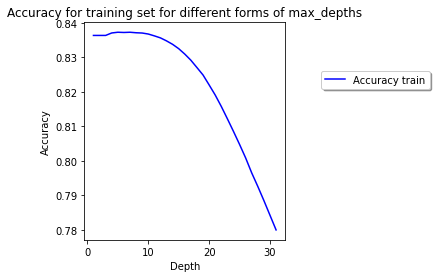

In [ ]:
from sklearn.metrics import roc_curve, auc
max_depths = 32
range_depths = range(1,32)
X_train, X_test, y_train, y_test = train_test_split(X, y1, test_size = 0.2, random_state = 0)
train_results = []


for i in range(1,32):
    clf = DecisionTreeClassifier(max_depth=i, splitter = 'random', random_state = 1)
    scores_train = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='accuracy')
    train_results.append((scores_train.mean()))

    
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(range_depths, np.array(train_results), 'b', label = "Accuracy train")
plt.title('Legend outside')
chartBox = ax.get_position()
ax.set_position([chartBox.x0, chartBox.y0, chartBox.width*0.6, chartBox.height])
ax.legend(loc='upper center', bbox_to_anchor=(1.45, 0.8), shadow=True, ncol=1)
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.title('Accuracy for training set for different forms of max_depths')
plt.show()


In [ ]:
train_results

[0.8363323290555489,
 0.8363323290555489,
 0.8363323290555489,
 0.8370448698544518,
 0.837255680813859,
 0.8371890645639122,
 0.8372539944945634,
 0.8371089566716741,
 0.8370288484025732,
 0.8367404587916656,
 0.8362083719552927,
 0.8356231610445608,
 0.8347554636252772,
 0.8337553769190773,
 0.8325006303512085,
 0.8309321965885216,
 0.8291546398282768,
 0.8270262927956532,
 0.8248726489683982,
 0.8220039339069182,
 0.8190736622146664,
 0.8157664610530379,
 0.8121919518564094,
 0.8085348044602118,
 0.8047680352314426,
 0.8008511685890518,
 0.7964991892672721,
 0.7925840082544466,
 0.7884892186608082,
 0.7842384276979174,
 0.7799910095300516]

Maximum at 5
<br>
Now turn to min_split:

In [ ]:
min_splits = 1.0
range_depths = np.arange(0.01,1.0, 0.05)

train_results = []


for i in np.arange(0.01,1.0, 0.05):
    clf = DecisionTreeClassifier(max_depth=5, min_samples_split=i, splitter = 'random', random_state = 1)
    scores_train = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='accuracy')
    train_results.append((scores_train.mean()))


In [ ]:
train_results

[0.8372573672966992,
 0.8363323290555489,
 0.8363323290555489,
 0.8363323290555489,
 0.8363323290555489,
 0.8363323290555489,
 0.8363323290555489,
 0.8363323290555489,
 0.8363323290555489,
 0.8363323290555489,
 0.8363323290555489,
 0.8363323290555489,
 0.8363323290555489,
 0.8363323290555489,
 0.8363323290555489,
 0.8363323290555489,
 0.8363323290555489,
 0.8363323290555489,
 0.8363323290555489,
 0.8363323290555489]

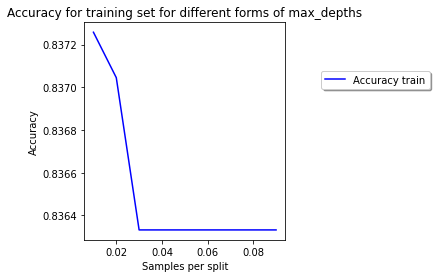

In [ ]:
range_min = np.arange(0.01,0.1, 0.01)

train_results = []

for i in np.arange(0.01,0.1, 0.01):
    clf = DecisionTreeClassifier(max_depth=5, min_samples_split=i, splitter = 'random', random_state = 1)
    scores_train = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='accuracy')
    train_results.append((scores_train.mean()))

fig = plt.figure()
ax = plt.subplot(111)
ax.plot(range_min, np.array(train_results), 'b', label = "Accuracy train")
plt.title('Legend outside')
chartBox = ax.get_position()
ax.set_position([chartBox.x0, chartBox.y0, chartBox.width*0.6, chartBox.height])
ax.legend(loc='upper center', bbox_to_anchor=(1.45, 0.8), shadow=True, ncol=1)
plt.xlabel('Samples per split')
plt.ylabel('Accuracy')
plt.title('Accuracy for training set for different forms of Samples per split')
plt.show()

In [ ]:
test_accuracy = []

for i in np.arange(0.0001,0.1, 0.01):
    
    clf = DecisionTreeClassifier(max_depth=5, min_samples_split=i,splitter = 'random', random_state = 1)
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    acc = accuracy_score(y_test, preds)
    test_accuracy.append(acc)

test_accuracy

[0.8364246563791213,
 0.8364246563791213,
 0.8362222784383169,
 0.8356320094443039,
 0.8356320094443039,
 0.8356320094443039,
 0.8356320094443039,
 0.8356320094443039,
 0.8356320094443039,
 0.8356320094443039]

We see that the first choice, 0.0001 is the best option

Now: min_sample_leaf

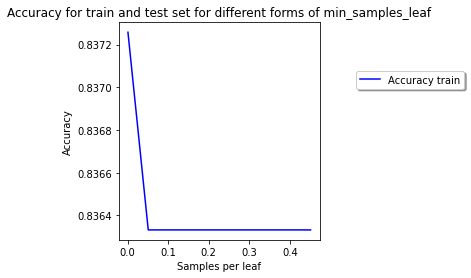

In [ ]:
range_tree_nodes = np.arange(0.001, 0.5, 0.05)

train_results = []

for i in np.arange(0.001,0.5, 0.05):
    clf = DecisionTreeClassifier(max_depth=5, min_samples_split=0.0001, min_samples_leaf = i, splitter = 'random', random_state = 1)
    scores_train = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='accuracy')
    train_results.append((scores_train.mean()))

fig = plt.figure()
ax = plt.subplot(111)
ax.plot(range_tree_nodes, np.array(train_results), 'b', label = "Accuracy train")
plt.title('Legend outside')
chartBox = ax.get_position()
ax.set_position([chartBox.x0, chartBox.y0, chartBox.width*0.6, chartBox.height])
ax.legend(loc='upper center', bbox_to_anchor=(1.45, 0.8), shadow=True, ncol=1)
plt.xlabel('Samples per leaf')
plt.ylabel('Accuracy')
plt.title('Accuracy for train and test set for different forms of min_samples_leaf')
plt.show()

Test accuracy

In [ ]:
test_accuracy = []

for i in np.arange(0.0001,0.5, 0.05):
    
    clf = DecisionTreeClassifier(max_depth=5, min_samples_split=0.0001,min_samples_leaf = i, splitter = 'random', random_state = 1)
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    acc = accuracy_score(y_test, preds)
    test_accuracy.append(acc)

np.asarray(test_accuracy).max()

0.8364246563791213

Min_sample_leaf at minimum of sample leaf of 0.0001

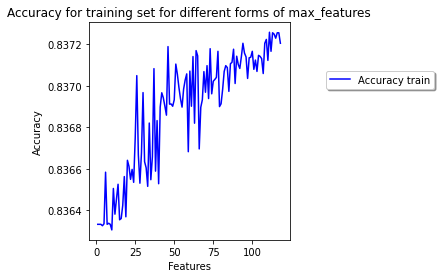

In [8]:
max_features = np.arange(1, X_train.shape[1])

train_results = []

for i in np.arange(1, X_train.shape[1]):
    clf = DecisionTreeClassifier(max_depth=5, min_samples_split=0.0001, min_samples_leaf = 0.0001, max_features = i, splitter = 'random', random_state = 1)
    scores_train = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='accuracy')
    train_results.append((scores_train.mean()))

fig = plt.figure()
ax = plt.subplot(111)
ax.plot(max_features, np.array(train_results), 'b', label = "Accuracy train")
plt.title('Legend outside')
chartBox = ax.get_position()
ax.set_position([chartBox.x0, chartBox.y0, chartBox.width*0.6, chartBox.height])
ax.legend(loc='upper center', bbox_to_anchor=(1.45, 0.8), shadow=True, ncol=1)
plt.xlabel('Features')
plt.ylabel('Accuracy')
plt.title('Accuracy for training set for different forms of max_features')
plt.show()

In [ ]:
max_depth=5
min_samples_split=0.0001
min_samples_leaf = 0.0001
max_features = 119

clf = DecisionTreeClassifier(max_depth=5, min_samples_split=0.0001,min_samples_leaf = 0.0001, max_features = 119, splitter = 'random', random_state = 1)
clf.fit(X, y1)
preds = clf.predict(X)
acc = accuracy_score(y1, preds)
print('For a Decision Tree Regressor we obtain that a combination of maximum depth of = %.1e, minimum sample split of %.2e, minimum sample leaf of = %.2e as well as maximum number of features of = %.2e leads to the accuracy = %.4f among the set.' % (max_depth, min_samples_split, min_samples_leaf, max_features, acc))

For a Decision Tree Regressor we obtain that a combination of maximum depth of = 5.0e+00, minimum sample split of 1.00e-04, minimum sample leaf of = 1.00e-04 as well as maximum number of features of = 1.19e+02 leads to the accuracy = 0.8371 among the set.


### Confusion Matrix and Classification Report

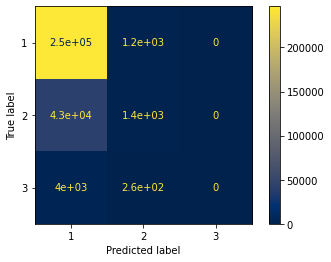

In [ ]:
plot_confusion_matrix(clf, X_test, y_test, cmap = 'cividis')

In [ ]:
yhat_clf = clf.predict(X_test)

confusion = confusion_matrix(y_test, yhat_clf)
confusion

array([[246543,   1201,      0],
       [ 43051,   1436,      0],
       [  3983,    261,      0]])

Here we see that the prediction of the trees are only giving the outcomes 1 and 2, which are the least severe accident classification. This is somewhat surprising, as there are literally no predictions for the lethal accidents category. However, the accuracy remains relatively high, as there are still a little over 83%  of the predictions correct. This has to be consumed with a large portion of caution, as an attentive reader might has already seen, that most of the observations are in the first category. This means that for every observed accident that has an accident severity of "severe" or "lethal", there are more than five "light" accidents. Hence, a plausible explanation for the prediction of only "light" accidents could be, that there are so many of this kind, that the regression tree cannot accurately distingusih the different severities. It is likely, that on every road where there was a fatal accident, there were also many minor accidents. Also, for harsh weather conditions, it might be that there were too many "light" accidents relative to more severe ones, that the model predicts the most observed accident in this specific category, which is allways the "light" accident severity.

In [ ]:
print(classification_report(y_test, yhat_clf))


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.84      1.00      0.91    247744
           2       0.50      0.03      0.06     44487
           3       0.00      0.00      0.00      4244

    accuracy                           0.84    296475
   macro avg       0.45      0.34      0.32    296475
weighted avg       0.78      0.84      0.77    296475

